![](https://wherobots.com/wp-content/uploads/2023/12/Inline-Blue_Black_onWhite@3x.png)

# Havasu Raster ETL example

In this example we demonstrate:

* working with the EuroSAT raster dataset as Havasu tables
* raster opertions 
* handling CRS transforms, and 
* benchmarking raster geometry operations


Read more about [Havasu](https://docs.wherobots.com/latest/references/havasu/introduction/), and [WherobotsDB Raster support](https://docs.wherobots.com/latest/references/havasu/raster/raster-overview/) in the documentation.

# Launch Spark Job

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col
from sedona.spark import *
import geopandas as gpd

# Define sedona context

In [2]:
config = SedonaContext.builder().appName('havasu-iceberg-raster-etl')\
    .config("spark.hadoop.fs.s3a.bucket.wherobots-examples.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")\
    .getOrCreate()
sedona = SedonaContext.create(config)

23/10/13 06:26:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/13 06:26:22 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/10/13 06:26:23 WARN S3ABlockOutputStream: Application invoked the Syncable API against stream writing to pvoaenkhn3/spark-logs/spark-252601722a3e4a238860d399d6d7b915.inprogress. This is unsupported


# Load Raster Datasets

## EuroSAT

In [31]:
eurosat_path = 's3://wherobots-examples/data/eurosat_small'
df_binary = sedona.read.format("binaryFile").option("pathGlobFilter", "*.tif").option("recursiveFileLookup", "true").load(eurosat_path)
df_geotiff = df_binary.withColumn("rast", expr("RS_FromGeoTiff(content)")).withColumn("name", expr("reverse(split(path, '/'))[0]")).select("name", "length", "rast")
df_geotiff.show(5, False)

+-----------------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|name             |length|rast                                                                                                                                                                                               |
+-----------------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|AnnualCrop_1.tif |107244|GridCoverage2D["", GeneralEnvelope[(624602.2348443292, 4876646.4119986), (625242.6000851067, 4877286.033637)], DefaultProjectedCRS["WGS 84 / UTM zone 35N"]]\n└ Image=RenderedImageAdapter[]\n     |
|AnnualCrop_10.tif|107244|GridCoverage2D["", GeneralEnvelope[(600895.0021822372, 4326629.904506601), (601535

# Save Raster Datasets to Havasu

In [32]:
sedona.sql("CREATE NAMESPACE IF NOT EXISTS wherobots.test_db")
sedona.sql("DROP TABLE IF EXISTS wherobots.test_db.eurosat_ms")
df_geotiff.coalesce(16).writeTo("wherobots.test_db.eurosat_ms").create()

## Save another copy of EuroSAT partitioned by SRID

In [33]:
sedona.sql("DROP TABLE IF EXISTS wherobots.test_db.eurosat_ms_srid")
df_rast_havasu = sedona.table("wherobots.test_db.eurosat_ms")
df_rast_havasu.withColumn("srid", expr("RS_SRID(rast) as srid"))\
    .sort('srid')\
    .write.format("havasu.iceberg").partitionBy("srid")\
    .saveAsTable("wherobots.test_db.eurosat_ms_srid")

## Reload Havasu Rasters

In [34]:
df_rast_havasu = sedona.table("wherobots.test_db.eurosat_ms")
df_rast_havasu_srid = sedona.table('wherobots.test_db.eurosat_ms_srid')

# Test Raster Functions

## Test Basic Raster Property Accessors

In [35]:
df_rast_havasu.selectExpr("name", "RS_Envelope(rast) as env", "RS_Metadata(rast) as meta").show(5)

+-----------------+--------------------+--------------------+
|             name|                 env|                meta|
+-----------------+--------------------+--------------------+
| AnnualCrop_1.tif|POLYGON ((624602....|[624602.234844329...|
|AnnualCrop_10.tif|POLYGON ((600895....|[600895.002182237...|
|AnnualCrop_11.tif|POLYGON ((499983....|[499983.561707, 5...|
|AnnualCrop_12.tif|POLYGON ((577311....|[577311.371324512...|
|AnnualCrop_13.tif|POLYGON ((595596....|[595596.768651201...|
+-----------------+--------------------+--------------------+
only showing top 5 rows



## Test Pixel Data Accessors

In [36]:
df_rast_havasu.selectExpr("name", "RS_Value(rast, ST_Centroid(RS_Envelope(rast))) as centroid_val").show(5, False)

+-----------------+------------+
|name             |centroid_val|
+-----------------+------------+
|AnnualCrop_1.tif |1343.0      |
|AnnualCrop_10.tif|1113.0      |
|AnnualCrop_11.tif|1776.0      |
|AnnualCrop_12.tif|1202.0      |
|AnnualCrop_13.tif|1364.0      |
+-----------------+------------+
only showing top 5 rows



## Test Band Accessors

In [37]:
df_rast_havasu.selectExpr("name", "RS_BandAsArray(rast, 1) as band1", "RS_BandAsArray(rast, 2) as band2", "RS_BandAsArray(rast, 3) as band3").show(5)

+-----------------+--------------------+--------------------+--------------------+
|             name|               band1|               band2|               band3|
+-----------------+--------------------+--------------------+--------------------+
| AnnualCrop_1.tif|[1420.0, 1420.0, ...|[1291.0, 1291.0, ...|[1291.0, 1291.0, ...|
|AnnualCrop_10.tif|[1133.0, 1133.0, ...|[902.0, 902.0, 90...|[1046.0, 1046.0, ...|
|AnnualCrop_11.tif|[1773.0, 1773.0, ...|[1325.0, 1325.0, ...|[901.0, 901.0, 87...|
|AnnualCrop_12.tif|[1388.0, 1388.0, ...|[1311.0, 1311.0, ...|[1360.0, 1360.0, ...|
|AnnualCrop_13.tif|[1650.0, 1650.0, ...|[1745.0, 1745.0, ...|[1833.0, 1833.0, ...|
+-----------------+--------------------+--------------------+--------------------+
only showing top 5 rows



## Test Preprocessing for DeepSatV2

In [38]:
df_extra_features = df_rast_havasu\
    .withColumn("band_red", expr("RS_BandAsArray(rast, 4)"))\
    .withColumn("band_green", expr("RS_BandAsArray(rast, 3)"))\
    .withColumn("band_nir", expr("RS_BandAsArray(rast, 8)"))\
    .withColumn("band_swir1", expr("RS_BandAsArray(rast, 12)"))\
    .withColumn("band_swir2", expr("RS_BandAsArray(rast, 13)"))\
    .withColumn("band_ndwi", expr("RS_NormalizedDifference(band_green, band_nir)"))\
    .withColumn("band_mndwi", expr("RS_NormalizedDifference(band_green, band_swir1)"))\
    .withColumn("band_ndmi", expr("RS_NormalizedDifference(band_nir, band_swir1)"))\
    .withColumn("band_ndvi", expr("RS_NormalizedDifference(band_nir, band_red)"))\
    .withColumn("band_awei", expr("RS_Subtract(RS_MultiplyFactor(RS_Subtract(band_green, band_swir1), 4), RS_Add(RS_MultiplyFactor(band_nir, 0.25), RS_MultiplyFactor(band_swir2, 2.75)))"))\
    .withColumn("band_builtup", expr("RS_NormalizedDifference(band_swir1, band_nir)"))\
    .withColumn("band_rvi", expr("RS_Divide(band_nir, RS_LogicalOver(band_red, RS_Array(array_size(band_red), 1e-12)))"))\
    .selectExpr("name", "RS_Mean(band_ndwi) as mean_ndwi", "RS_Mean(band_mndwi) as mean_mndwi", "RS_Mean(band_ndmi) as mean_ndmi", "RS_Mean(band_ndvi) as mean_ndvi", "RS_Mean(band_awei) as mean_awei", "RS_Mean(band_builtup) as mean_builtup", "RS_Mean(band_rvi) as mean_rvi")
df_extra_features.show(5)

+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+
|             name|       mean_ndwi|       mean_mndwi|        mean_ndmi|        mean_ndvi|        mean_awei|     mean_builtup|        mean_rvi|
+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+
| AnnualCrop_1.tif|0.24019287109375|  0.3056591796875|   0.068935546875|-0.18885009765625|2276.625732421875|-0.06893310546875| 1.5046044921875|
|AnnualCrop_10.tif|0.53470947265625|-0.03570068359375|-0.47993408203125|-0.56128662109375|11558.86083984375|  0.4799365234375|5.65989990234375|
|AnnualCrop_11.tif|  0.158486328125|-0.17229248046875| -0.3105517578125|   -0.22107421875|6362.411376953125| 0.31055908203125|  1.869560546875|
|AnnualCrop_12.tif|   0.42466796875| 0.01308837890625|   -0.40275390625| -0.5088330078125|8556.160217285156|  0.4027587890625| 3.4891455

In [39]:
df_extra_features = df_rast_havasu\
    .withColumn("ndvi", expr("RS_MapAlgebra(rast, 'd', 'out = (rast[3] - rast[7]) / (rast[3] + rast[7]);', null)"))\
    .withColumn("awei", expr("RS_MapAlgebra(rast, 'd', 'out = (0.25 * rast[7] + 2.75 * rast[12]) - 4 * (rast[11] - rast[2]);', null)"))\
    .withColumn("rvi", expr("RS_MapAlgebra(rast, 'd', 'out = rast[7] / max(rast[3], 0.000001);', null)"))\
    .withColumn("mean_ndvi", expr("RS_Mean(RS_BandAsArray(ndvi, 1))"))\
    .withColumn("mean_awei", expr("RS_Mean(RS_BandAsArray(awei, 1))"))\
    .withColumn("mean_rvi", expr("RS_Mean(RS_BandAsArray(rvi, 1))"))
df_extra_features.show(5)

+-----------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------------+
|             name|length|                rast|                ndvi|                awei|                 rvi|           mean_ndvi|        mean_awei|          mean_rvi|
+-----------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------------+
| AnnualCrop_1.tif|107244|GridCoverage2D[""...|GridCoverage2D[""...|GridCoverage2D[""...|GridCoverage2D[""...|-0.18884719739670083|2276.625732421875|1.5045622201750313|
|AnnualCrop_10.tif|107244|GridCoverage2D[""...|GridCoverage2D[""...|GridCoverage2D[""...|GridCoverage2D[""...| -0.5613203012338317|11558.86083984375| 5.659844075934628|
|AnnualCrop_11.tif|107244|GridCoverage2D[""...|GridCoverage2D[""...|GridCoverage2D[""...|GridCoverage2D[""...|-0.22102594667106096|6362.411376953125|1.8695

In [40]:
df_extra_features.where("mean_awei > 0.5").count()

200

# Data Visualization

We'll visualize the bounding boxes of the rasters in EuroSAT. Here we can see the importance of handling the CRS of rasters properly.

* `df_rast_env` contains envelopes of rasters in EuroSAT
* `df_rast_env_srid` contains envelopes of rasters in EuroSAT transformed to CRS:4326 (EPSG:4326 in lon-lat axis order)

In [41]:
df_rast_env = df_rast_havasu.selectExpr('name', "RS_Envelope(rast) as env", "RS_SRID(rast) as srid")

df_rast_env_4326 = df_rast_havasu.selectExpr('name', "RS_Envelope(rast) as env", "RS_SRID(rast) as srid")\
    .withColumn("env_4326", expr("ST_Transform(env, concat('epsg:', srid), 'epsg:4326')"))\
    .select("name", "env_4326", "srid")

Now let's plot the datasets. We plot the transformed envelopes of the rasters, and color the geometries by the original SRID of the rasters. We know that the CRS of the rasters are in UTM, so they appears to be grouped by vertical stripes.

In [42]:
rasterMap_4326 = SedonaKepler.create_map()
SedonaKepler.add_df(rasterMap_4326, df_rast_env_4326, name="raster-bounds")
rasterMap_4326

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'raster-bounds': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

You can see that the rasters in `df_rast_env` are not plotted correctly because the rasters are in various UTM CRS, and it is not meaningful to plot rasters in different CRS together.

The reason why plotting the envelopes of rasters without considering their CRS results in a long stripe is that the CRS of the rasters are in UTM, and rasters in different UTM zones have the same coordinate range since they share the same false easting and northing.

<Axes: >

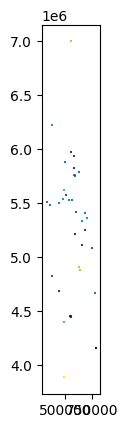

In [43]:
gdf_rast_env = df_rast_env.toPandas()
gdf_rast_env = gpd.GeoDataFrame(gdf_rast_env, geometry='env')
gdf_rast_env['boundary'] = gdf_rast_env.boundary
gdf_rast_env.set_geometry('boundary', inplace=True)
gdf_rast_env.plot(column='srid')

# Use a better partitioner for faster range query

Now let's use the H3 cell ID of the centroid of the raster in EPSG:4326 to partition the dataset. This will result in a better partitioning scheme for range query.

In [45]:
df_rast_havasu_h3 = df_rast_havasu\
    .withColumn("centroid", expr("ST_Transform(ST_Centroid(RS_Envelope(rast)), concat('epsg:', RS_SRID(rast)), 'epsg:4326')"))\
    .withColumn("h3_cell_id", expr("array_max(ST_H3CellIDs(centroid, 1, false))"))

If we plot the centroid of rasters using different colors for different H3 cell IDs, we can see that the rasters are partitioned into different H3 cells.

<Axes: >

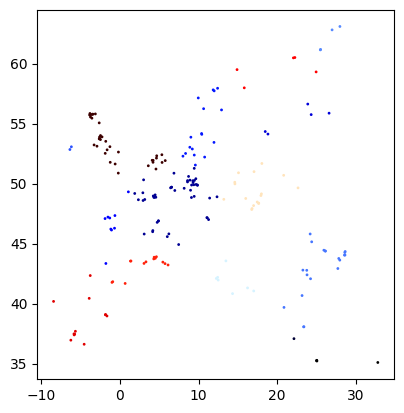

In [46]:
gdf_rast_havasu_h3 = gpd.GeoDataFrame(df_rast_havasu_h3.select("centroid", "h3_cell_id").toPandas(), geometry='centroid', crs='EPSG:4326')
gdf_rast_havasu_h3.plot(column='h3_cell_id', cmap='flag', markersize=1)

Now let's save the dataset partitioned by H3 cell ID and reload it.

In [47]:
sedona.sql("DROP TABLE IF EXISTS wherobots.test_db.eurosat_ms_h3")
df_rast_havasu_h3.sort("h3_cell_id").write.format("havasu.iceberg").partitionBy("h3_cell_id").saveAsTable("wherobots.test_db.eurosat_ms_h3")

In [48]:
df_rast_havasu_h3 = sedona.table('wherobots.test_db.eurosat_ms_h3')

# Benchmarking Raster Functions

This is just a simple benchmark running on EuroSAT dataset. It could give the user a rough idea of how havasu in-db raster performs compared to GeoTiff when processing lots of tiny raster images.

In [49]:
import time

def benchmark_query(df_dict, bench_func, num_runs=1):
    cost_dict = {}
    for name, df in df_dict.items():
        print(f"Running benchmark for {name}")
        cost_dict[name] = []
        for i in range(1, num_runs + 1):
            print(f"Run #{i} for {name}")
            start = time.time()
            result = bench_func(df)
            end = time.time()
            cost = end - start
            print(f"Run #{i} for {name} took {cost} seconds, result: {result}")
            cost_dict[name].append(cost)
    # print summary
    for name, costs in cost_dict.items():
        print(f"Summary for {name} - runs: {len(costs)}, mean: {sum(costs)/len(costs)}, min: {min(costs)}, max: {max(costs)}")
    return cost_dict

In [50]:
df_dict = {
    'havasu': df_rast_havasu,
    'havasu_srid': df_rast_havasu_srid,
    'havasu_h3': df_rast_havasu_h3,
    'geotiff': df_geotiff
}

## Scanning the entire dataset and extract basic raster properties

In [51]:
def bench_func(df):
    return df.withColumn("num_bands", expr("RS_NumBands(rast)")).where("num_bands IS NOT NULL").count()

benchmark_query(df_dict, bench_func, num_runs=1)

Running benchmark for havasu
Run #1 for havasu


Run #1 for havasu took 1.2383785247802734 seconds, result: 200
Running benchmark for havasu_srid
Run #1 for havasu_srid


Run #1 for havasu_srid took 2.4093034267425537 seconds, result: 200
Running benchmark for havasu_h3
Run #1 for havasu_h3


Run #1 for havasu_h3 took 2.278440475463867 seconds, result: 200
Running benchmark for geotiff
Run #1 for geotiff


Run #1 for geotiff took 23.893847465515137 seconds, result: 200
Summary for havasu - runs: 1, mean: 1.2383785247802734, min: 1.2383785247802734, max: 1.2383785247802734
Summary for havasu_srid - runs: 1, mean: 2.4093034267425537, min: 2.4093034267425537, max: 2.4093034267425537
Summary for havasu_h3 - runs: 1, mean: 2.278440475463867, min: 2.278440475463867, max: 2.278440475463867
Summary for geotiff - runs: 1, mean: 23.893847465515137, min: 23.893847465515137, max: 23.893847465515137


{'havasu': [1.2383785247802734],
 'havasu_srid': [2.4093034267425537],
 'havasu_h3': [2.278440475463867],
 'geotiff': [23.893847465515137]}

## Scanning the entire dataset and extract bands

In [52]:
def bench_func(df):
    return df.selectExpr("name", "RS_BandAsArray(rast, 1) as band1", "RS_BandAsArray(rast, 2) as band2")\
        .selectExpr("RS_NormalizedDifference(band1, band2) as band_nd")\
        .where("array_size(band_nd) > 0")\
        .count()

benchmark_query(df_dict, bench_func, num_runs=1)

Running benchmark for havasu
Run #1 for havasu


Run #1 for havasu took 1.517106056213379 seconds, result: 200
Running benchmark for havasu_srid
Run #1 for havasu_srid


Run #1 for havasu_srid took 2.2840769290924072 seconds, result: 200
Running benchmark for havasu_h3
Run #1 for havasu_h3


Run #1 for havasu_h3 took 2.2571442127227783 seconds, result: 200
Running benchmark for geotiff
Run #1 for geotiff


Run #1 for geotiff took 16.517739295959473 seconds, result: 200
Summary for havasu - runs: 1, mean: 1.517106056213379, min: 1.517106056213379, max: 1.517106056213379
Summary for havasu_srid - runs: 1, mean: 2.2840769290924072, min: 2.2840769290924072, max: 2.2840769290924072
Summary for havasu_h3 - runs: 1, mean: 2.2571442127227783, min: 2.2571442127227783, max: 2.2571442127227783
Summary for geotiff - runs: 1, mean: 16.517739295959473, min: 16.517739295959473, max: 16.517739295959473


{'havasu': [1.517106056213379],
 'havasu_srid': [2.2840769290924072],
 'havasu_h3': [2.2571442127227783],
 'geotiff': [16.517739295959473]}

## Scanning the entire dataset and extract pixel values

In [53]:
def bench_func(df):
    return df.selectExpr("RS_Value(rast, ST_Centroid(RS_Envelope(rast))) as centroid_val")\
        .where("centroid_val IS NOT NULL")\
        .count()
    
benchmark_query(df_dict, bench_func, num_runs=1)

Running benchmark for havasu
Run #1 for havasu


Run #1 for havasu took 1.3494784832000732 seconds, result: 200
Running benchmark for havasu_srid
Run #1 for havasu_srid


Run #1 for havasu_srid took 1.4471850395202637 seconds, result: 200
Running benchmark for havasu_h3
Run #1 for havasu_h3


Run #1 for havasu_h3 took 2.0529072284698486 seconds, result: 200
Running benchmark for geotiff
Run #1 for geotiff


Run #1 for geotiff took 11.425729274749756 seconds, result: 200
Summary for havasu - runs: 1, mean: 1.3494784832000732, min: 1.3494784832000732, max: 1.3494784832000732
Summary for havasu_srid - runs: 1, mean: 1.4471850395202637, min: 1.4471850395202637, max: 1.4471850395202637
Summary for havasu_h3 - runs: 1, mean: 2.0529072284698486, min: 2.0529072284698486, max: 2.0529072284698486
Summary for geotiff - runs: 1, mean: 11.425729274749756, min: 11.425729274749756, max: 11.425729274749756


{'havasu': [1.3494784832000732],
 'havasu_srid': [1.4471850395202637],
 'havasu_h3': [2.0529072284698486],
 'geotiff': [11.425729274749756]}

## Range query

We run several range queries on the EuroSAT dataset using the following query windows. The query windows were specified as rectangles in EPSG:4326.

In [54]:
query_windows = {
    'spain_madrid': 'ST_SetSRID(ST_PolygonFromEnvelope(-4.7803,39.5882, -2.7782,40.9276), 4326)',
    'cesko_praha': 'ST_SetSRID(ST_PolygonFromEnvelope(13.2747,49.2297, 16.3189,51.0516), 4326)',
    'france_paris': 'ST_SetSRID(ST_PolygonFromEnvelope(1.299,48.156, 3.566,49.575), 4326)',
}

In [55]:
def bench_query_func(df, qw_expr):
    return df.where(f"RS_Intersects(rast, {qw_expr})").count()

for qw_name, qw_exr in query_windows.items():
    print(f"Running benchmark using query window {qw_name}")
    benchmark_query(df_dict, lambda df: bench_query_func(df, qw_exr), num_runs=1)

Running benchmark using query window spain_madrid
Running benchmark for havasu
Run #1 for havasu


Run #1 for havasu took 1.1232705116271973 seconds, result: 1
Running benchmark for havasu_srid
Run #1 for havasu_srid
Run #1 for havasu_srid took 0.4072136878967285 seconds, result: 1
Running benchmark for havasu_h3
Run #1 for havasu_h3
Run #1 for havasu_h3 took 0.3614509105682373 seconds, result: 1
Running benchmark for geotiff
Run #1 for geotiff


Run #1 for geotiff took 10.502366542816162 seconds, result: 1
Summary for havasu - runs: 1, mean: 1.1232705116271973, min: 1.1232705116271973, max: 1.1232705116271973
Summary for havasu_srid - runs: 1, mean: 0.4072136878967285, min: 0.4072136878967285, max: 0.4072136878967285
Summary for havasu_h3 - runs: 1, mean: 0.3614509105682373, min: 0.3614509105682373, max: 0.3614509105682373
Summary for geotiff - runs: 1, mean: 10.502366542816162, min: 10.502366542816162, max: 10.502366542816162
Running benchmark using query window cesko_praha
Running benchmark for havasu
Run #1 for havasu


Run #1 for havasu took 1.198798656463623 seconds, result: 3
Running benchmark for havasu_srid
Run #1 for havasu_srid
Run #1 for havasu_srid took 0.25706958770751953 seconds, result: 3
Running benchmark for havasu_h3
Run #1 for havasu_h3
Run #1 for havasu_h3 took 0.28501081466674805 seconds, result: 3
Running benchmark for geotiff
Run #1 for geotiff


Run #1 for geotiff took 9.114201307296753 seconds, result: 3
Summary for havasu - runs: 1, mean: 1.198798656463623, min: 1.198798656463623, max: 1.198798656463623
Summary for havasu_srid - runs: 1, mean: 0.25706958770751953, min: 0.25706958770751953, max: 0.25706958770751953
Summary for havasu_h3 - runs: 1, mean: 0.28501081466674805, min: 0.28501081466674805, max: 0.28501081466674805
Summary for geotiff - runs: 1, mean: 9.114201307296753, min: 9.114201307296753, max: 9.114201307296753
Running benchmark using query window france_paris
Running benchmark for havasu
Run #1 for havasu


Run #1 for havasu took 1.0251774787902832 seconds, result: 5
Running benchmark for havasu_srid
Run #1 for havasu_srid
Run #1 for havasu_srid took 0.31498003005981445 seconds, result: 5
Running benchmark for havasu_h3
Run #1 for havasu_h3
Run #1 for havasu_h3 took 0.31872129440307617 seconds, result: 5
Running benchmark for geotiff
Run #1 for geotiff


Run #1 for geotiff took 8.38875150680542 seconds, result: 5
Summary for havasu - runs: 1, mean: 1.0251774787902832, min: 1.0251774787902832, max: 1.0251774787902832
Summary for havasu_srid - runs: 1, mean: 0.31498003005981445, min: 0.31498003005981445, max: 0.31498003005981445
Summary for havasu_h3 - runs: 1, mean: 0.31872129440307617, min: 0.31872129440307617, max: 0.31872129440307617
Summary for geotiff - runs: 1, mean: 8.38875150680542, min: 8.38875150680542, max: 8.38875150680542
